# Denoising (DAE)

## Introduction
L'objectif est de créer un Denoising auto-encoder (DAE) afin de débruiter les images avant de les donner au modèle de captioning.

## 0. Imports & variables

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, AveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
training_folder = './processed_data/photos/'
noisy_folder = './noisy_data/'
test_folder = "./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/"
BATCH_SIZE = 64

## 1. Création d'images bruitées
La première étape consiste à créer des images bruitées à partir de nos données. Cela permettra d'entraîner le modèle à reconstruire l'image originale en fonction de l'image bruitée.
### Chargement des images
Commençons par charger nos images originales.

In [ ]:
def load_images_from_folder(folder_path):
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append((filename, img))
    return images

original_images = load_images_from_folder(training_folder)

  0%|          | 0/29979 [00:00<?, ?it/s]

### Ajout de bruit et sauvegarde
Ajoutons un bruit aléatoire à nos images.   
Chaque image se voit appliquer 1, 2 ou 3 bruits choisis aléatoirement parmi les bruits suivants :
- Gaussian
- Salt and pepper
- Speckle   
   
Utiliser une combinaison aléatoire de plusieurs bruits permet au modèle de devenir plus générique en étant capable de débruiter différents niveaux et types de bruits. On pourrait aussi faire varier les paramètres de bruits pour obtenir encore plus d'hétérogénéité dans nos bruitages d'images mais cela rend la convergence difficile pour le modèle. Avec plus de performances pour l'entraînement, cette solution est à envisager. 3 types de bruits aléatoires et des paramètres fixes donnent des résultats acceptables.   
On enregistre ensuite nos images bruitées dans un dossier afin de les réutiliser plus tard.

In [ ]:
def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

def add_random_noise_to_images(images, noisy_folder, mean=0, sigma=25, salt_pepper_ratio=0.02, speckle_sigma=0.1):
    clear_folder(noisy_folder)
    noise_types = ['gaussian', 'salt_pepper', 'speckle']

    for filename, img in tqdm(images):
        row, col, ch = img.shape
        noisy = img.astype(np.float32)

        num_noises_to_apply = random.randint(1, len(noise_types))
        noises_to_apply = random.sample(noise_types, num_noises_to_apply)

        for noise_type in noises_to_apply:
            if noise_type == 'gaussian':
                gauss = np.random.normal(mean, sigma, (row, col, ch))
                noisy += gauss

            elif noise_type == 'salt_pepper':
                num_salt = np.ceil(salt_pepper_ratio * noisy.size * 0.5)
                num_pepper = num_salt

                salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in [row, col]]
                noisy[salt_coords[0], salt_coords[1], :] = 255

                pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in [row, col]]
                noisy[pepper_coords[0], pepper_coords[1], :] = 0

            elif noise_type == 'speckle':
                gauss = np.random.randn(row, col, ch)
                noisy += noisy * gauss * speckle_sigma

        noisy = np.clip(noisy, 0, 255).astype(np.uint8)
        noisy_filename = "noisy_" + filename
        cv2.imwrite(os.path.join(noisy_folder, noisy_filename), noisy)

add_random_noise_to_images(original_images, noisy_folder)

  0%|          | 0/29979 [00:00<?, ?it/s]

## 2. Chargement des données originales et bruitées
Chargeons nos images originales et bruitées dans 3 datasets différents :
- Dataset d'entraînement
- Dataset de validation
- Dataset de test   
   
Afin d'obtenir ces 3 datasets, nous allons suivre différentes étapes.   
D'abord, nous allons créer un couple de datasets train/val pour chaque type d'images (originales/bruitées).

In [ ]:
def load_and_normalize_from_directory(directory, batch_size=64, img_size=(304, 304), validation_split=None, subset=None):
    dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode=None,
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=123,
        validation_split=validation_split,
        subset=subset
    )
    
    dataset = dataset.map(lambda x: x / 255.0, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [ ]:
originals_train = load_and_normalize_from_directory(training_folder, batch_size=BATCH_SIZE, validation_split=0.3, subset='training')
originals_val = load_and_normalize_from_directory(training_folder, batch_size=BATCH_SIZE, validation_split=0.3, subset='validation')
noisies_train = load_and_normalize_from_directory(noisy_folder, batch_size=BATCH_SIZE, validation_split=0.3, subset='training')
noisies_val = load_and_normalize_from_directory(noisy_folder, batch_size=BATCH_SIZE, validation_split=0.3, subset='validation')

Found 29979 files belonging to 1 classes.
Using 20986 files for training.
Found 29979 files belonging to 1 classes.
Using 8993 files for validation.
Found 29979 files belonging to 1 classes.
Using 20986 files for training.
Found 29979 files belonging to 1 classes.
Using 8993 files for validation.


Ensuite, nous allons regrouper nos datasets en deux datasets : entraînement et validation.  
Chaque dataset est composé de batches qui sont composés de couples d'images (bruitée et originale).

In [ ]:
def combine_datasets(dataset1, dataset2):
    combined_dataset = tf.data.Dataset.zip((dataset1, dataset2))
    return combined_dataset

train_dataset = combine_datasets(noisies_train, originals_train)
val_dataset = combine_datasets(noisies_val, originals_val)

Nous allons diviser le jeu de validation en 2 afin d'obtenir un jeu de test et un jeu de validation.

In [ ]:
def split_validation_dataset(val_dataset):
    """
    Divise un jeu de données de validation en deux parties égales.

    :param val_dataset: Un objet tf.data.Dataset.
    :return: Deux objets tf.data.Dataset.
    """
    total_batches = 0
    for _ in val_dataset:
        total_batches += 1

    half_batches = total_batches // 2

    new_val_dataset = val_dataset.take(half_batches)
    test_dataset = val_dataset.skip(half_batches)

    return new_val_dataset, test_dataset

val_dataset, test_dataset = split_validation_dataset(val_dataset)

In [ ]:
def count_images_in_dataset(dataset):
    total_images = 0
    for images, _ in dataset:
        total_images += tf.shape(images)[0]
    return total_images.numpy()

print(f"Taille du jeu d'entraînement: {count_images_in_dataset(train_dataset)}")
print(f"Taille du jeu de validation: {count_images_in_dataset(val_dataset)}")
print(f"Taille du jeu de test: {count_images_in_dataset(test_dataset)}")

Taille du jeu d'entraînement: 20986
Taille du jeu de validation: 4480
Taille du jeu de test: 4513


Visualisons quelques couples d'images (bruitée et originale).

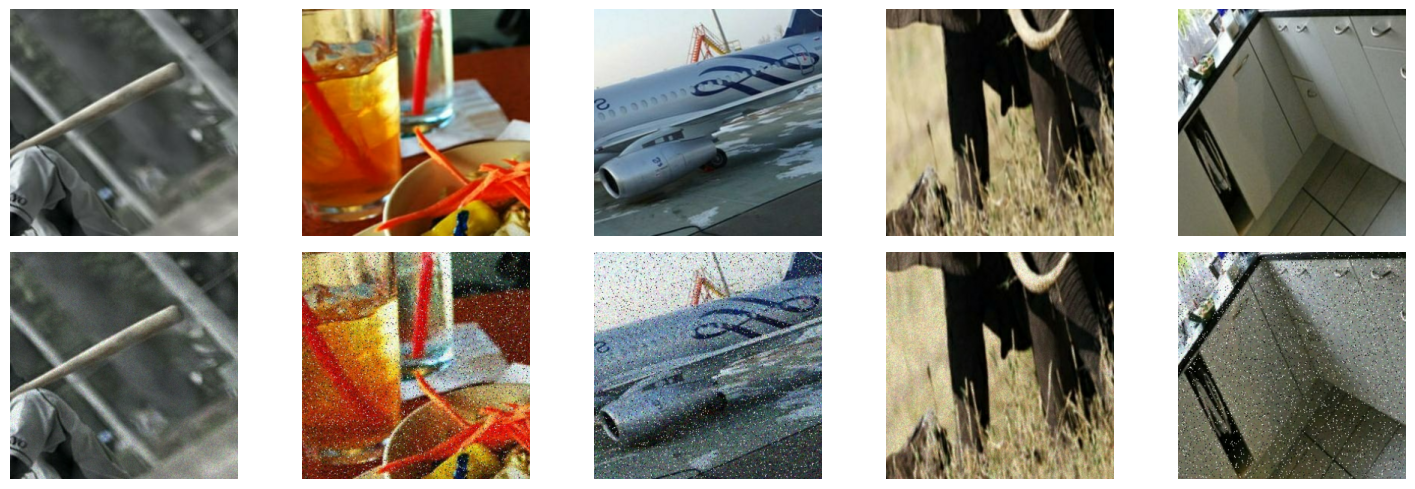

In [ ]:
def display_pairs(train_dataset, num_samples=5):
    samples = list(train_dataset.take(num_samples))
    
    noisies_samples = [pair[0][0].numpy() for pair in samples]
    originals_samples = [pair[1][0].numpy() for pair in samples]
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[0, i].imshow(originals_samples[i])
        axes[1, i].imshow(noisies_samples[i])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

display_pairs(train_dataset)

## 3. Création du modèle
Le choix des couches de notre réseau de neurones est déterminant concernant sa précision.    
Après de nombreux essais sur les couches et les paramètres, voici une visualisation du modèle retenu:   
   
![image.png](./images/DAE.png) 

In [ ]:
dae = None
with tf.device('/GPU:0'):
    input_shape = (304, 304, 3)
    activation = LeakyReLU(alpha=0.1)
    
    encoder = Sequential()
    encoder.add(Input(shape=input_shape))
    encoder.add(Conv2D(32, (3, 3), activation=activation, padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(64, (3, 3), activation=activation, padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))  
    encoder.add(Conv2D(128, (3, 3), activation=activation, padding='same'))
    encoder.add(MaxPooling2D((2, 2), padding='same'))   
    
    decoder = Sequential()
    decoder.add(Conv2D(128, (3, 3), activation=activation, padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(64, (3, 3), activation=activation, padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(32, (3, 3), activation=activation, padding='same'))
    decoder.add(UpSampling2D((2, 2)))  
    decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  
    
    dae = Sequential([encoder, decoder])
    dae.compile(optimizer='adam', loss='mean_squared_error')
    dae.build((None, 304, 304, 3))
    encoder.summary()
    decoder.summary()
    dae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 152, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 76, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 128)      0

Différents essais ont été menés avec des couches "average pooling" et des activations "relu".   
Initialement, nous entraînions notre modèle avec la fonction de perte "binary crossentropy". Cependant, après avoir essayé avec "mean squared error" afin de pénaliser plus fortement les grosses erreurs, on a constaté un résultat similaire avec une convergence plus rapide. Nous avons donc sélectionné cette fonction de perte.

## 4. Entraînement du modèle

Vous pouvez suivre l'avancée de l'entrainement avec la commande `tensorboard --logdir logs/fit/dae --bind_all`

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/dae/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_directory = f"weights/dae/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

with tf.device('/GPU:0'):
    dae.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/30
328/328 [==============================] - 194s 553ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 2/30
328/328 [==============================] - 176s 536ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/30
328/328 [==============================] - 175s 533ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/30
328/328 [==============================] - 176s 533ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/30
328/328 [==============================] - 173s 525ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/30
328/328 [==============================] - 173s 525ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/30
328/328 [==============================] - 174s 529ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/30
328/328 [==============================] - 175s 531ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/30
328/328 [==============================] - 176s 534ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/30
328/328 [==============================] - 175s 532m

Chargeons les poids du modèle avant le surapprentissage et avant que le modèle arrête de progresser.

In [ ]:
dae.load_weights("./weights/dae/20231017-115719/25-0.0014.h5")

## 5. Evaluation du modèle
L'évaluation du modèle permet de valider ses performances. Nous allons la réaliser sur le jeu de test, c'est à dire sur des images que le modèle n'a jamais vu auparavant.
### 5.1. Evaluation sur le jeu de test
L'évaluation de la performance d'un auto-encodeur débruiteur (DAE) nécessite l'utilisation de métriques spécifiques qui analysent à la fois la précision et la qualité de l'image reconstruite.

- **Loss (Perte)**: Cette métrique est une mesure quantitative de l'erreur totale entre les pixels de l'image reconstruite et ceux de l'image originale. Elle est calculée en utilisant la moyenne des erreurs quadratiques (MSE), et elle est exprimée en tant que valeur scalaire. Plus la valeur de la perte est faible, plus la reconstruction est précise, ce qui indique une performance élevée du modèle.

- **PSNR (Peak Signal-to-Noise Ratio)**: Le PSNR est une mesure de la qualité de reconstruction qui compare le niveau maximal possible d'un signal à la puissance du bruit qui affecte la fidélité de sa représentation. Il est exprimé en décibels (dB). Un PSNR plus élevé indique une erreur plus faible et donc une meilleure qualité de l'image reconstruite, ce qui est crucial pour évaluer la performance visuelle d'un DAE.

- **SSIM (Structural Similarity Index Measure)**: Le SSIM évalue la similarité entre deux images en comparant des caractéristiques structurelles locales. Il prend en compte la luminance, le contraste et la structure, et son score varie entre -1 et 1. Un SSIM proche de 1 indique une similitude très élevée et donc une qualité de reconstruction supérieure, reflétant une meilleure performance perceptuelle du modèle.


| Métrique | Description                                                                                      | Intervalles de Résultats                 |
|----------|--------------------------------------------------------------------------------------------------|-----------------------------------------|
| Loss     | Mesure quantitative de l'erreur entre les images originales et reconstruites.                    | Plus la valeur est faible, meilleur est le modèle (0 = parfait).              |
| PSNR     | Mesure de la qualité de l'image basée sur le rapport signal-bruit, exprimée en dB.               | > 30 dB: Bon, > 40 dB: Excellent.       |
| SSIM     | Évalue la similarité structurelle entre deux images, score entre -1 et 1.                        | Proche de 1: Excellent, < 0.5: Médiocre.|

In [ ]:
def calculate_metrics(original, reconstructed):
    data_range = 1.0
    psnr_val = psnr(original, reconstructed, data_range=data_range)
    ssim_val = ssim(original, reconstructed, multichannel=True, data_range=data_range, win_size=min(7, min(original.shape[0:2])), channel_axis=2)
    return psnr_val, ssim_val

def evaluate_model(dataset, model):
    """
    Calcule les métriques PSNR et SSIM moyennes pour un jeu de données de test.

    :param dataset: Jeu de données de test contenant les images originales.
    :param model: Le modèle DAE entraîné.
    :return: Le PSNR moyen et le SSIM moyen sur l'ensemble du jeu de données.
    """
    loss = model.evaluate(dataset)
    total_psnr = 0.0
    total_ssim = 0.0
    total_images = 0

    for batch in tqdm(dataset):
        _, original_images = batch
        reconstructed_images = model.predict(original_images, verbose=0)

        for original, reconstructed in zip(original_images, reconstructed_images):
            original = np.squeeze(original)
            reconstructed = np.squeeze(reconstructed) 
            current_psnr, current_ssim = calculate_metrics(original, reconstructed)

            total_psnr += current_psnr
            total_ssim += current_ssim
            total_images += 1

    average_psnr = total_psnr / total_images
    average_ssim = total_ssim / total_images
    print(f"Model Loss: {loss}")
    print(f"Model average PSNR: {average_psnr}")
    print(f"Model average SSIM: {average_ssim}")
    
evaluate_model(test_dataset, dae)

71/71 [==============================] - 20s 205ms/step - loss: 0.0014


  0%|          | 0/71 [00:00<?, ?it/s]

Model Loss: 0.0013629881432279944
Model average PSNR: 31.00578629085344
Model average SSIM: 0.8850902068015347


On peut voir ici que le calcul de ces métriques permet de valider la performance de notre DAE.  
Affichons quelques trios d'images (originale, bruitée, reconstruite) et les scores de métriques associés afin d'obtenir une interprétation plus visuelle des performances de notre DAE.

In [ ]:
def display_original_daeoutput_and_metrics(originals, noisy_images, reconstructions):
    """Affiche les images originales, bruitées et les reconstructions côte à côte, et imprime les métriques."""
    n = len(originals)
    
    plt.figure(figsize=(20, 4 * n))
    
    for i in range(n):
        psnr_val, ssim_val = calculate_metrics(originals[i], reconstructions[i])
        
        if noisy_images is not None:
            ax = plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(noisy_images[i])
            plt.title("Bruitée")
            plt.axis("off")
        
        ax = plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(originals[i])
        plt.title(f"Originale\nPSNR: {psnr_val:.2f}\nSSIM: {ssim_val:.2f}")
        plt.axis("off")
        
        ax = plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(reconstructions[i])
        plt.title("Reconstruction")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

2/2 [==============================] - 0s 294ms/step


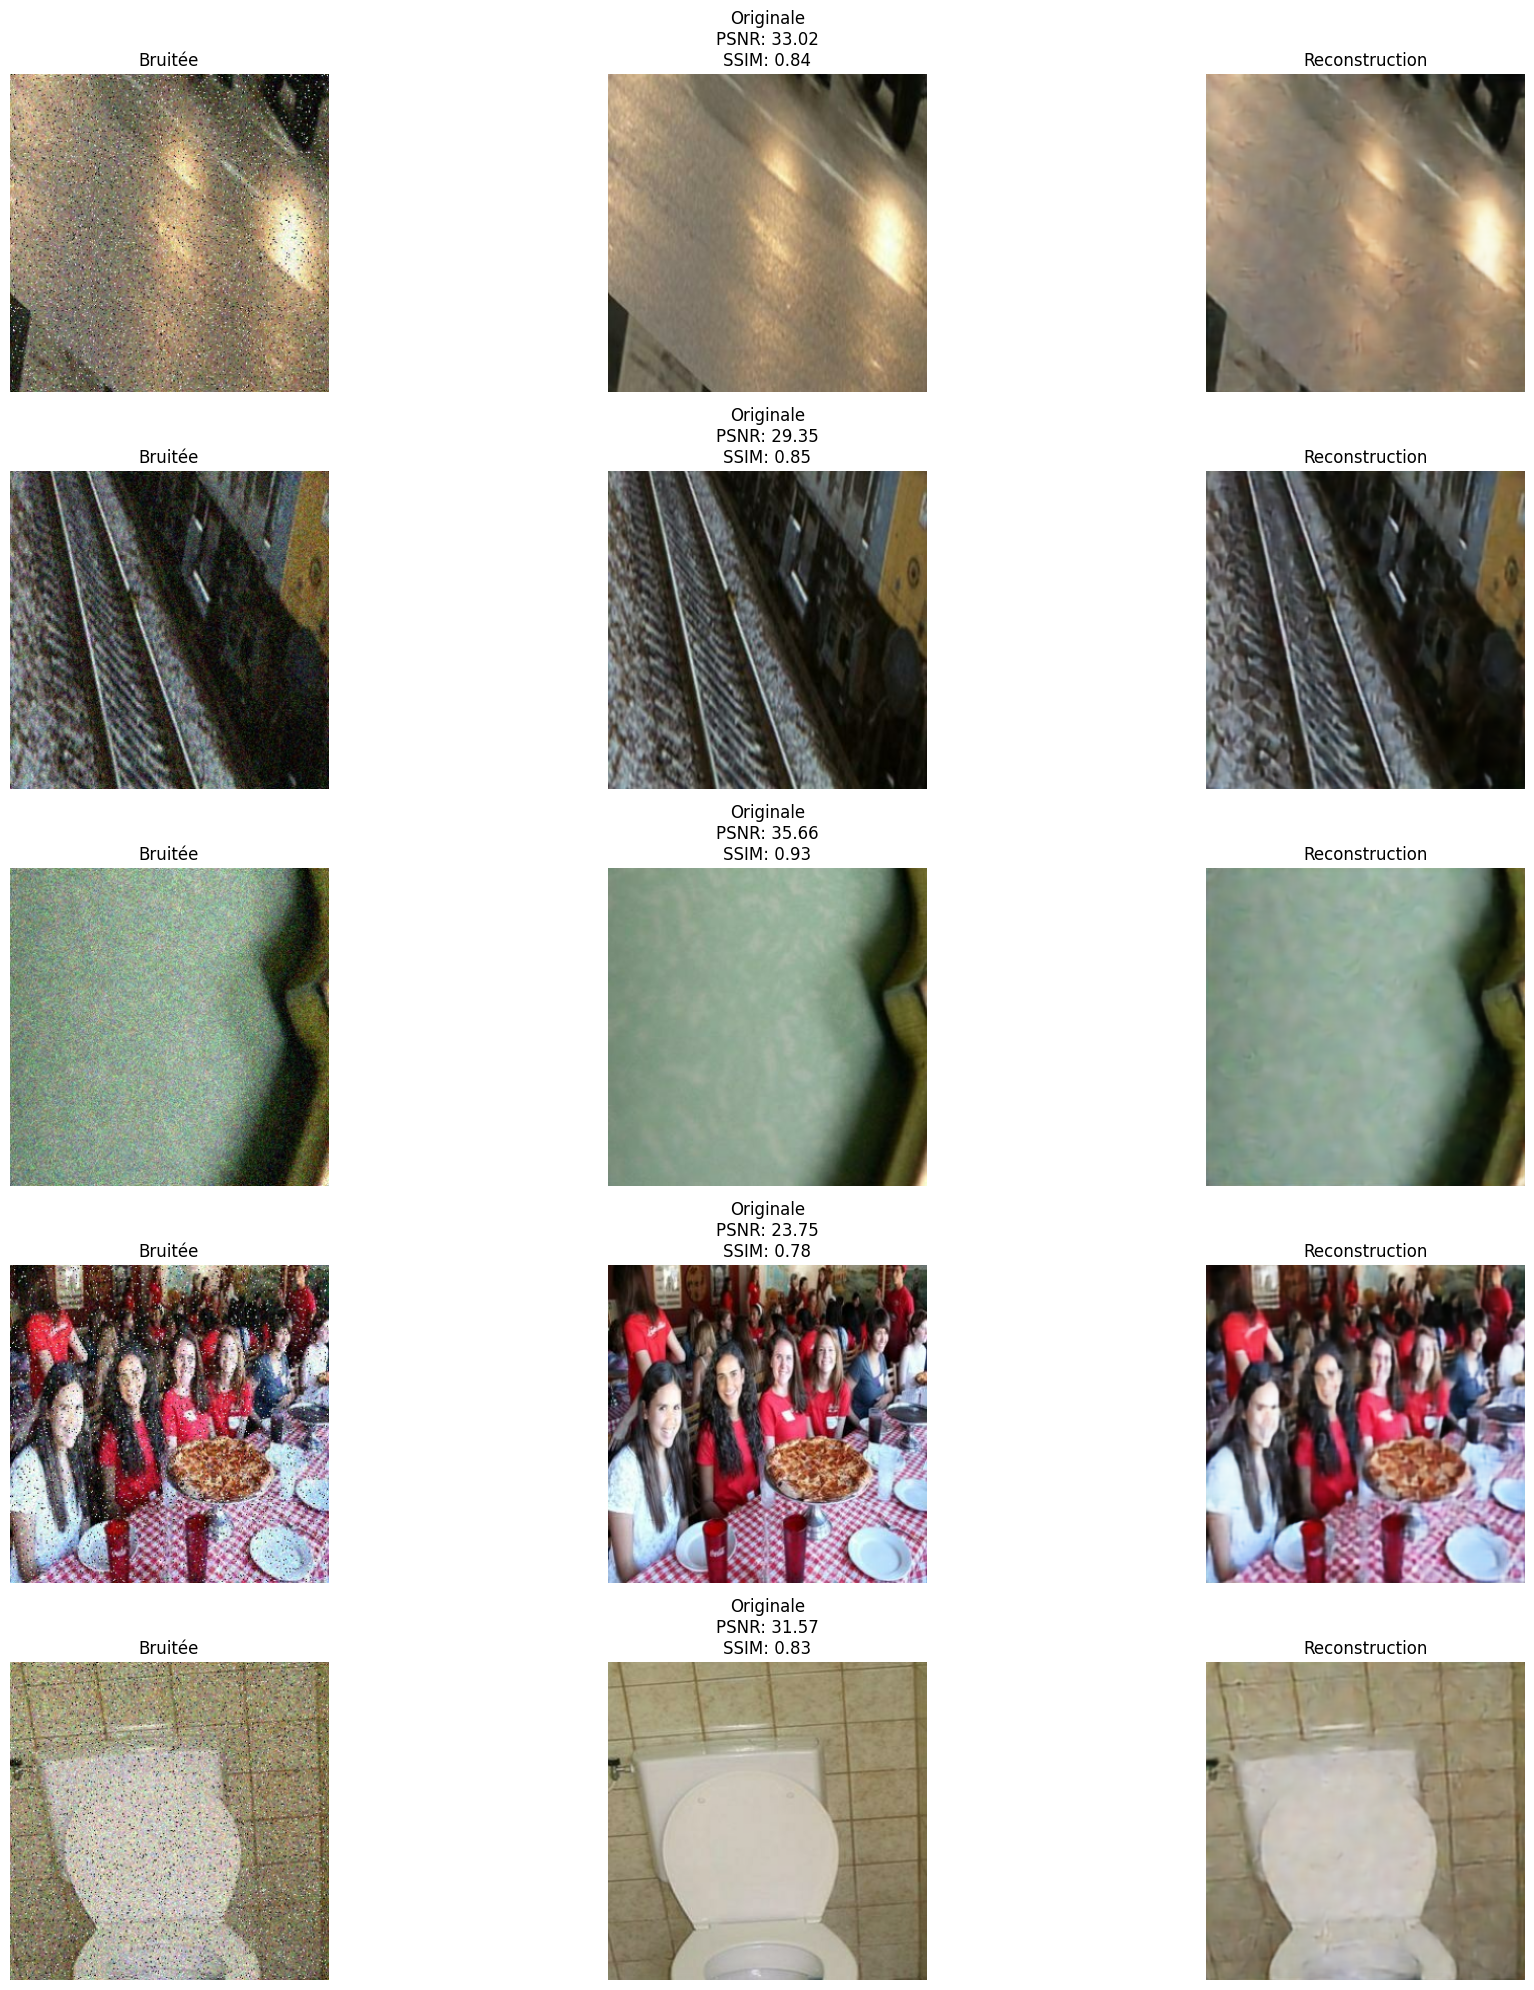

In [ ]:
for noisy_images, original_images in test_dataset.take(1):  
    noisy_images_np = noisy_images.numpy()  
    original_images_np = original_images.numpy()  
    reconstructions = dae.predict(noisy_images)  

display_original_daeoutput_and_metrics(original_images_np[:5], noisy_images_np[:5], reconstructions[:5])

### 5.2. Evaluation sur les données réelles
Maintenant que le jeu de test a permis de valider notre modèle, testons le sur les images réelles fournies par le CESI.
#### Chargement des données

In [ ]:
def load_data_into_dataframe(path):
    filenames = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    df = pd.DataFrame({'filename': filenames})
    return df

df = load_data_into_dataframe(test_folder)

#### Analyse des données réelles
**Taille des images**   
Vérifions que les images n'ont pas de tailles aberrantes.

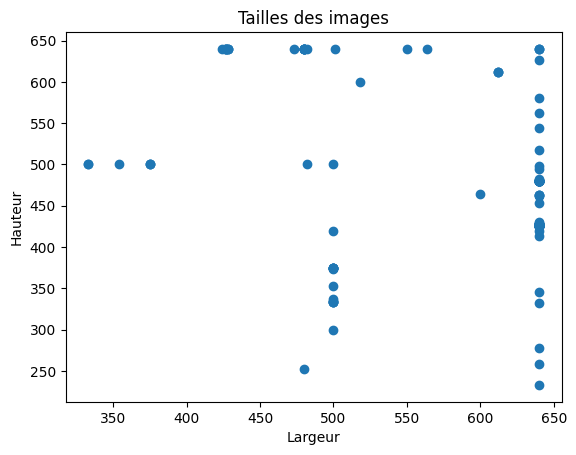

In [ ]:
def plot_image_sizes(df):
    sizes = [Image.open(f).size for f in df['filename']]
    widths, heights = zip(*sizes)
    
    plt.scatter(widths, heights)
    plt.xlabel('Largeur')
    plt.ylabel('Hauteur')
    plt.title('Tailles des images')
    plt.show()

plot_image_sizes(df)

**Types de couleurs**   
Vérifions que les images sont toutes en RGB.

In [ ]:
def plot_color_modes(df):
    color_modes = [Image.open(f).mode for f in df['filename']]
    mode_counts = pd.Series(color_modes).value_counts()
    print(mode_counts)

plot_color_modes(df)

RGB    148
Name: count, dtype: int64


**Chargement des données réelles et pré-processing**   
Chargeons les données au format 304*304 et normalisons-les.

In [ ]:
real_dataset = load_and_normalize_from_directory('./OneDrive_2022-09-22/Dataset Livrable 2/Dataset/')

Found 148 files belonging to 1 classes.


**Comparaison des images originales et des sorties du DAE**   
Evaluons notre modèle sur les données réelles en calculant les métriques et en visualisant les images originales et reconstruites.   
On notera ici que les images de test fournies par le CESI ne sont pas bruitées ce qui ne permet pas d'évaluer notre modèle correctement. C'est pour cette raison que nous avons dû évaluer le DAE sur un jeu de test.   
Malheureusement, le bruit de ce jeu de test a été ajouté avec des fonctions de bruit tout comme le jeu d'entraînement. Il serait très intéressant de tester notre modèle sur des images qui contiennent un bruit involontaire (transmissions, mauvaise qualité, ...). Malheureusement, le dataset du CESI ne nous le permet pas.   
Comme ces images ne sont pas bruitées le PSNR qui étudie la reconstruction par rapport au bruit à tendance à être plus faible.

2/2 [==============================] - 0s 354ms/step


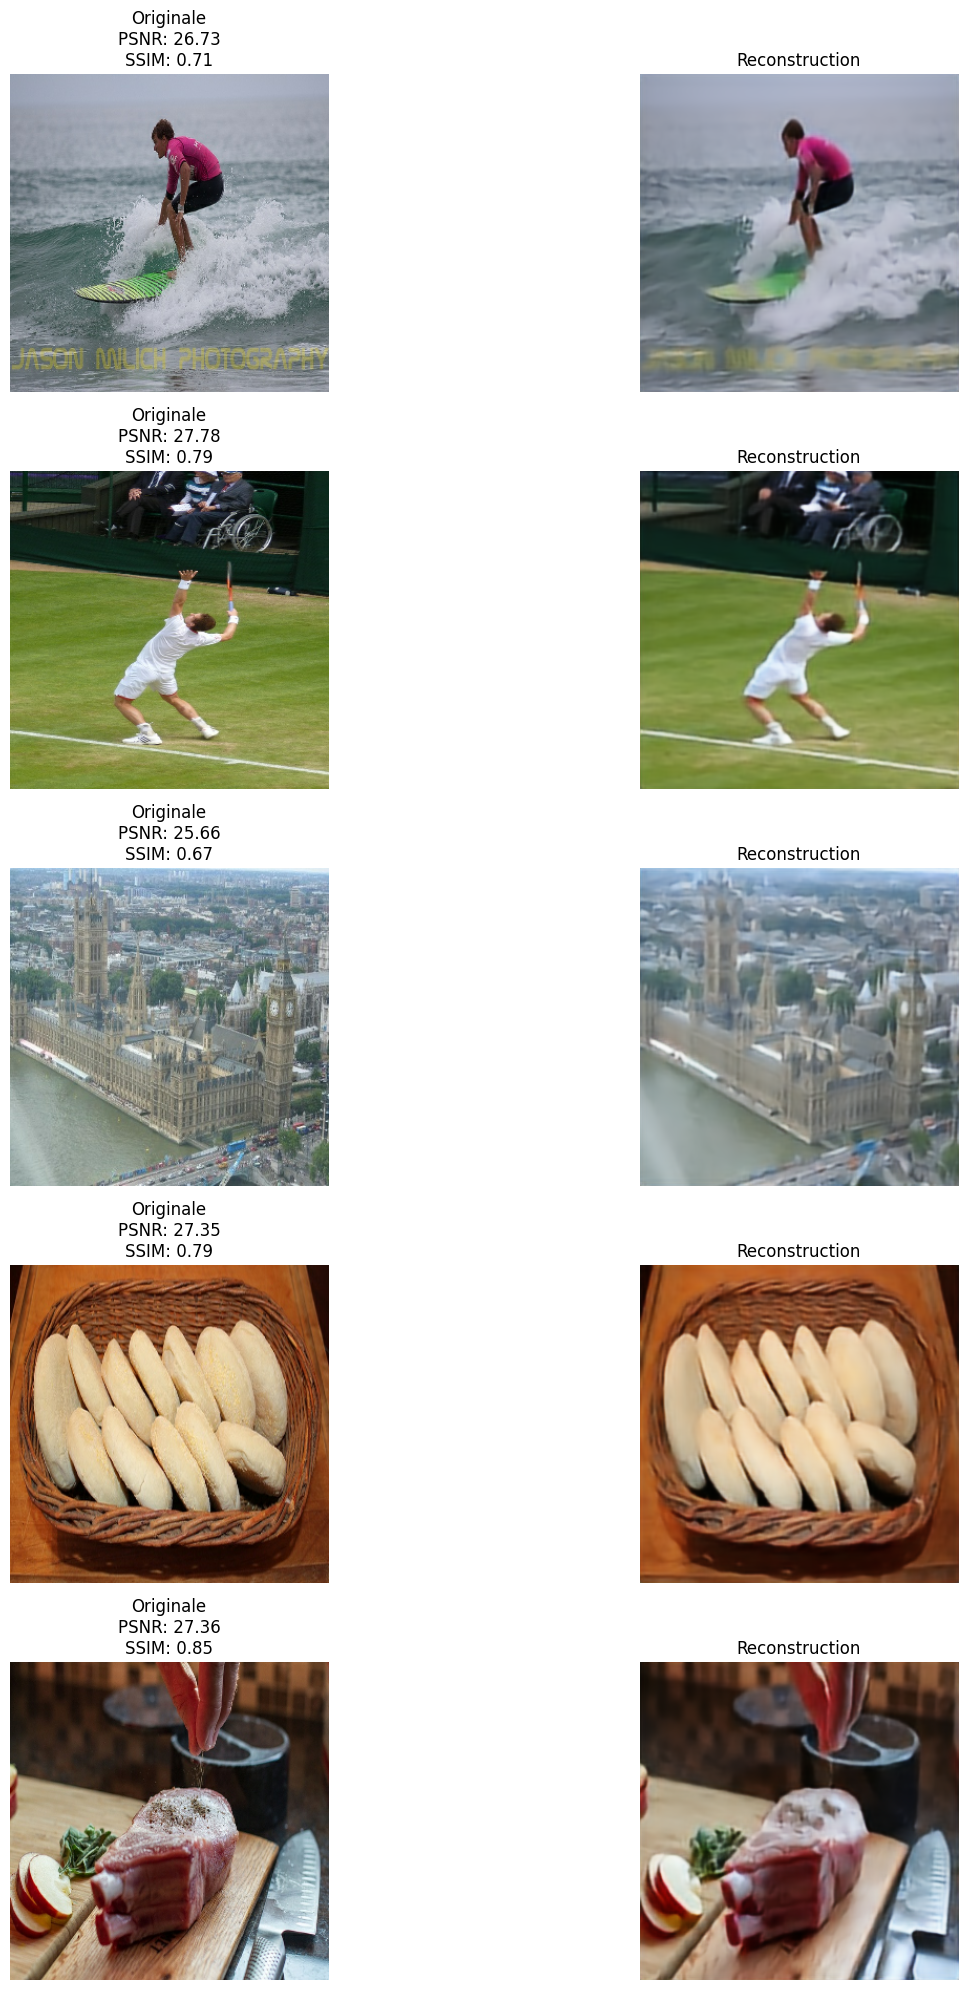

In [ ]:
for images in real_dataset.take(1):
    originals = images.numpy()
    reconstructions = dae.predict(images)

display_original_daeoutput_and_metrics(originals[:5], None, reconstructions[:5])

## Conclusion
Nous avons pu valider les performances de notre DAE (Denoising auto-encoder). Il nous permettra d'assurer la qualité des images transmises au modèle d'image-captioning.

In [ ]:
dae.save("./models/dae.h5")